In [2]:
# https://towardsdatascience.com/decrypting-your-machine-learning-model-using-lime-5adc035109b5
import numpy as np
import lime
import lime.lime_tabular
from lime import lime_image
import sklearn.ensemble
from matplotlib.colors import LinearSegmentedColormap
import matplotlib
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
# import time
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [3]:
# https://github.com/marcotcr/lime
# https://homes.cs.washington.edu/~marcotcr/blog/lime/
# https://arxiv.org/abs/1602.04938
# https://arxiv.org/pdf/2008.11092.pdf
# https://towardsdatascience.com/explainable-ai-xai-methods-part-5-global-surrogate-models-9c228d27e13a
# https://towardsdatascience.com/explainable-ai-xai-a-guide-to-7-packages-in-python-to-explain-your-models-932967f0634b
# https://github.com/oracle/Skater


In [4]:
def make_cmap(high_vals=False,low_vals=False):
	precip_clevs = [0, 1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 70, 100, 150]
	if high_vals==True:
		# precip_clevs = [0, 20, 25, 30, 40, 50, 70, 100, 125, 150, 175,200, 225, 250, 300, 350, 400, 500]
		precip_clevs = [0, 20, 40, 60, 80, 100, 125, 150, 175, 200, 225, 250, 300, 350, 400, 500]
	if low_vals == True:
		precip_clevs = [0, 2, 4, 6, 8, 10, 12, 14, 16, 19, 20, 22, 24, 26, 28, 30]
	# precip_cmap = matplotlib.colors.ListedColormap(metpy.plots.ctables.colortables["precipitation"][:len(precip_clevs)-1], 'precipitation')
	# precip_norm = matplotlib.colors.BoundaryNorm(precip_clevs, precip_cmap.N)

	tc_colours = [(255/255,255/255,255/255), # no rain
				(169/255, 209/255, 222/255), # drizzle 0-1
				(137/255, 190/255, 214/255), # drizzle 1-2
				(105/255, 160/255, 194/255), # drizzle 2-3
				(93/255, 168/255, 98/255), # drizzle 3-5
				(128/255, 189/255, 100/255), # very light rain 5-7
				(165/255, 196/255, 134/255), # light rain 7-10
				(233/255, 245/255, 105/255), # rain 10-15
				(245/255, 191/255, 105/255), # heavy rain 15-20
				(245/255, 112/255, 105/255), # heavier rain 20-25
				(245/255, 105/255, 149/255), # real heavy rain 25-30
				(240/255, 93/255, 154/255), # intense rain 30-40
				(194/255, 89/255, 188/255), # super intense rain 40-50
				(66/255, 57/255, 230/255), # insane amount of rain 50-70
				(24/255, 17/255, 153/255), # you do not want to be caught in this rain 70-100
				(9/255, 5/255, 87/255), # I can't belive the scle goes up this high 100-150
	]
	if high_vals == False:
		N = 16
	else:
		N=16
	precip_cmap = LinearSegmentedColormap.from_list('tc_colours',tc_colours,N=N) #increasing N makes it smoother
	precip_norm = matplotlib.colors.BoundaryNorm(precip_clevs, precip_cmap.N,extend='max')
	return precip_cmap,precip_norm

In [229]:
def explain(explainer,storm,X_vec,simple_rf_pipeline,segmenter,block=False,data=False):
    
    rain = tcs[storm,:,:]*150
    sample = X_vec[storm]

    if block == True:
        rain[40:60,40:60] = np.mean(rain)
        sample[40:60,40:60] = np.mean(rain)

        

    explanation = explainer.explain_instance(sample, 
                                         classifier_fn = simple_rf_pipeline.predict_proba, 
                                         top_labels=6, hide_color=0, num_samples=20000, segmentation_fn=segmenter)
    
    
    # if increasing number of segments then increase number of samples
    sns.set_style("white")
    sns.set_context("notebook")
    #Select the same class explained on the figures above.
    ind =  explanation.top_labels[0]

    #Map each explanation weight to the corresponding superpixel
    dict_heatmap = dict(explanation.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
    if data==False:
        #Plot. The visualization makes more sense if a symmetrical colorbar is used.
        precip_cmap,precip_norm = make_cmap()
        precip_clevs = [0, 1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 70, 100, 150]
        precip_norm = matplotlib.colors.BoundaryNorm(precip_clevs, precip_cmap.N,extend='max')
        fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14, 6))
        divider1 = make_axes_locatable(ax1)
        cax1 = divider1.append_axes('right', size='5%', pad=0.2)
        divider2 = make_axes_locatable(ax2)
        cax2 = divider2.append_axes('right', size='5%', pad=0.2)

        # first panel
        m = ax1.imshow(rain,interpolation='nearest',cmap = precip_cmap,norm=precip_norm)
        ax1.set_title("Tropical cyclone rainfall",size=18,pad=15)
        cb1 = plt.colorbar(m,cax=cax1,fraction = 2,label='Rain')
        cb1.set_label(label='Rain',size=16,labelpad=10)
        cb1.ax.tick_params(labelsize=12) 

        # second panel
        m = ax2.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
        ax2.set_title("Explanation weight",size=18,pad=15)
        cb2 = plt.colorbar(m,cax=cax2,fraction = 2.8,label='Weight')
        cb2.set_label(label='Weight',size=16,labelpad=10)
        cb2.ax.tick_params(labelsize=12) 
    
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax2.set_xticklabels([])
        ax2.set_yticklabels([])
        # ax2.tick_params(axis='x', labelsize=12)
        # ax2.tick_params(axis='y', labelsize=12)
        # ax1.tick_params(axis='x', labelsize=12) 
        # ax1.tick_params(axis='y', labelsize=12) 
        ax1.text(-0.15, 1.1, 'a.', transform=ax1.transAxes, size=22, weight='bold')
        ax2.text(-0.15, 1.1, 'b.', transform=ax2.transAxes, size=22, weight='bold')
        plt.tight_layout()
        plt.show()
    else:
        return heatmap
    

In [6]:
# 10 x 10 rain to 100 x 100 rain model - getting its original training input
feature_names_part2 = ['rain','mslp','q-925','u-200','u-850','v-200','v-850']
train_filepath_part2 = '/user/home/al18709/work/tc_data_flipped/train_combined_X.npy'
train_X_part2 = np.load(train_filepath_part2)
print(train_X_part2.shape)
train_part2 = train_X_part2[0,:,:,0]

# 10 x 10 rain to 100 x 100 rain model - making predictions from output of other model
input_filepath_part2 = '/user/home/al18709/work/gan_predictions_20/validation_pred-opt_scalar_test_run_3.npy'
critic_pred1 = np.load('/user/home/al18709/work/gan_predictions_20/validation_disc_pred-opt_modular_part2_raw.npy')[:,0,0]
gen_pred1 = np.load('/user/home/al18709/work/gan_predictions_20/validation_pred-opt_modular_part2_raw.npy')
critic_pred2 = np.load('/user/home/al18709/work/gan_predictions_20/validation_disc_pred-opt_modular_part2_patchloss_raw.npy')[:,0,0]
gen_pred2 = np.load('/user/home/al18709/work/gan_predictions_20/validation_pred-opt_modular_part2_patchloss_raw.npy')
# critic_pred2_test = np.load('/user/home/al18709/work/gan_predictions_20/test_disc_pred-opt_modular_part2_raw.npy')[:,0,0]
# real_part2 = np.load('/user/home/al18709/work/gan_predictions_20/validation_pred-opt_scalar_test_run_3.npy')
real = np.load(f"/user/home/al18709/work/gan_predictions_20/validation_real-opt_modular_part2_raw.npy")
input_part2 = np.load(input_filepath_part2)
print(input_part2.shape)
# train_part2 = train_X_part2[0,:,:,0]

# 1 x 6 model to 100 x 100 model
feature_names_part1 = ['mslp','u-850','v-850','wind_shear','centre_lat','centre_lon']

# TODO: this filepath might need to change
train_filepath_part1 = '/user/work/al18709/tc_data_flipped/KE_tracks/train_X.npy'
train_X_part1 = np.load(train_filepath_part1)
inputs_part1 = np.load('/user/work/al18709/tc_data_flipped/KE_tracks/valid_X.npy')
test_inputs_part1 = np.load('/user/work/al18709/tc_data_flipped/KE_tracks/test_X.npy')
pred_part1 = np.load('/user/home/al18709/work/gan_predictions_20/validation_pred-opt_scalar_test_run_3.npy')[0,:,:,0]
real_part1 = np.load('/user/home/al18709/work/gan_predictions_20/validation_real-opt_scalar_test_run_3.npy')[0,:,:,0]
print(train_X_part1.shape)
train_part1 = train_X_part1[:,:]
print(pred_part1.shape)
print(real_part1.shape)
print(inputs_part1.shape)
print(critic_pred2.shape)

(45623, 10, 10, 7)
(15930, 10, 10, 20)
(45623, 6)
(10, 10)
(10, 10)
(15930, 6)
(15930,)


In [7]:
explainer = lime.lime_tabular.LimeTabularExplainer(train_part1, feature_names=feature_names_part1, mode='regression')
# do the critic maybe? Whats the difference between a good score and a bad score
# explainer = lime_image.LimeImageExplainer() 
# feed it images on decision boundary, one that defo a TC and one that's defo not
# it tells you how the features have contributed to wasserstein distance
# bLIMEy would do the decision tree model instead of the linear model, but might not be for images.
# bLIMEy probably does have surrogate image explainer
# will have to build model settings and implement lime in same script.
# use gradients to calculate the counterfactuals - so go to TC class and find the closest prediction to that sample that actually isn't a TC
# also use ensemble predictions for discriminator
# https://github.com/So-Cool/bLIMEy/blob/master/ECML-PKDD_2023/limetree_explanations.ipynb
# https://github.com/fat-forensics/events/blob/master/README.md
# https://events.fat-forensics.org
# saliance

In [8]:
rf1 = sklearn.ensemble.RandomForestRegressor(n_estimators=1000)
rf2 = sklearn.ensemble.RandomForestRegressor(n_estimators=1000)

In [9]:
rf1.fit(inputs_part1, critic_pred1)
rf2.fit(inputs_part1, critic_pred2)

RandomForestRegressor(n_estimators=1000)

In [10]:
min1 = critic_pred1.min()
i = np.where(np.logical_and(critic_pred1 >= min1, critic_pred1 <= (min1 + 5)))[0]
i1 = i[20]
max1 = critic_pred1.max()
j = np.where(np.logical_and(critic_pred1 <= max1, critic_pred1 >= (max1 - 5)))[0]
j1 = j[20]
print(i1,j1)

min2 = critic_pred2.min()
[i2] = np.where([critic_pred2 == min2])[1]
max2 = critic_pred2.max()
[j2] = np.where([critic_pred2 == max2])[1]
print(i2,j2)

170 8522
5233 11563


In [11]:
print(i)

[   24    60    61 ... 15910 15911 15912]


In [12]:
print(critic_pred1)

[11.74314213 11.30103779 11.76886654 ... 14.92933083 12.17943954
 13.0296526 ]


In [13]:
print(min1)
print(max1)
print(min2)
print(max2)

5.512174606323242
25.534744262695312
0.9062801599502563
70.67640686035156


In [14]:
# https://link.springer.com/article/10.1007/s10618-013-0342-x
# decision boundary in n-dimensional space
# hard to visualise so have to split into 2D space

In [15]:
# define inputs
f1 = inputs_part1[:10000,0]
f2 = inputs_part1[:10000,1]
f3 = inputs_part1[:10000,2]
f4 = inputs_part1[:10000,3]
f5 = inputs_part1[:10000,4]
f6 = inputs_part1[:10000,5]

In [16]:
# get explainations/predictions

scores_1 = rf1.predict(inputs_part1[:10000])
scores_2 = rf2.predict(inputs_part1[:10000])


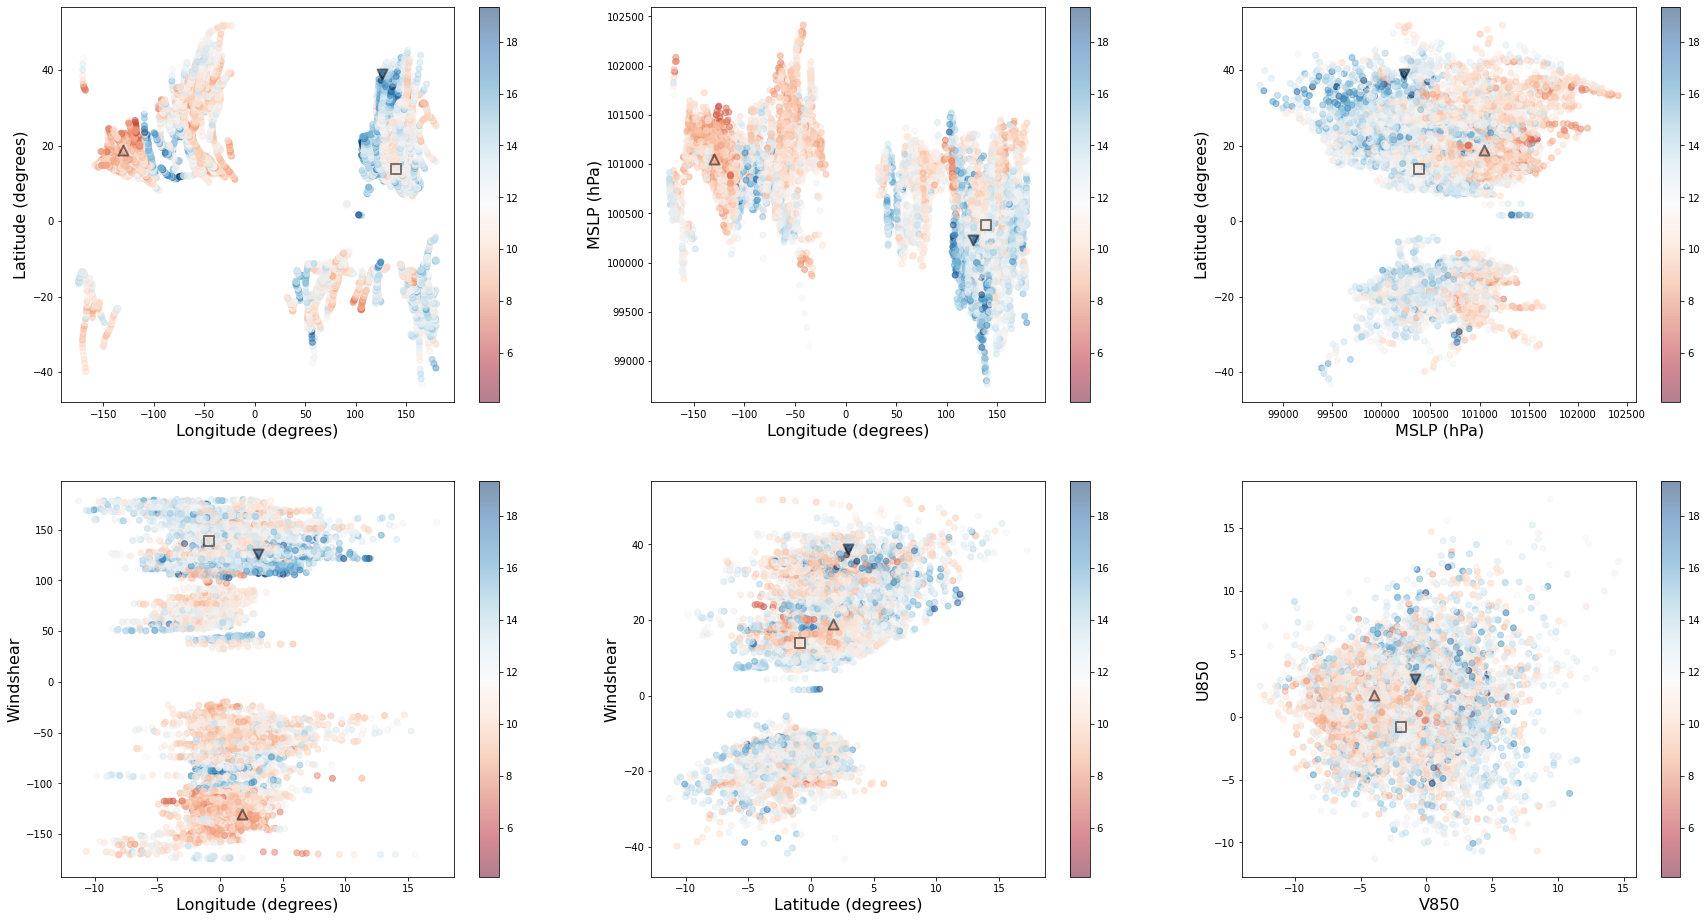

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30, 16))

boundary = np.mean(critic_pred1)
diff1 = np.max(scores_1)-boundary
diff2 = np.min(scores_1)-boundary
if diff1 >= diff2:
    vmin = boundary - (diff1 - 3)
    vmax = boundary + (diff1 - 3)
else:
    vmin = boundary - (diff2 - 3)
    vmax = boundary + (diff2 - 3)

cmap = 'RdBu'
fsize=16
size = 100
lw=2

# panel 1
m = axes[0,0].scatter(f6,f5, c=scores_1, cmap=cmap,alpha=0.5,vmin=vmin,vmax=vmax)
axes[0,0].scatter(f6[976],f5[976], c=scores_1[976], cmap=cmap,alpha=0.5,vmin=vmin,vmax=vmax,s=size,marker='s', edgecolors='black',linewidths=lw)
axes[0,0].scatter(f6[i1],f5[i1], c=scores_1[i1], cmap=cmap,alpha=0.5,vmin=vmin,vmax=vmax,s=size,marker='^', edgecolors='black',linewidths=lw)
axes[0,0].scatter(f6[j1],f5[j1], c=scores_1[j1], cmap=cmap,alpha=0.5,vmin=vmin,vmax=vmax,s=size,marker='v', edgecolors='black',linewidths=lw)
axes[0,0].set_xlabel('Longitude (degrees)',fontsize=fsize)
axes[0,0].set_ylabel('Latitude (degrees)',fontsize=fsize)

# panel 2
axes[0,1].scatter(f6,f1,c=scores_1, cmap=cmap,alpha=0.5,vmin=vmin,vmax=vmax)
axes[0,1].scatter(f6[976],f1[976], c=scores_1[976], cmap=cmap,alpha=0.5,vmin=vmin,vmax=vmax,s=size,marker='s', edgecolors='black',linewidths=lw)
axes[0,1].scatter(f6[i1],f1[i1], c=scores_1[i1], cmap=cmap,alpha=0.5,vmin=vmin,vmax=vmax,s=size,marker='^', edgecolors='black',linewidths=lw)
axes[0,1].scatter(f6[j1],f1[j1], c=scores_1[j1], cmap=cmap,alpha=0.5,vmin=vmin,vmax=vmax,s=size,marker='v', edgecolors='black',linewidths=lw)
axes[0,1].set_xlabel('Longitude (degrees)',fontsize=fsize)
axes[0,1].set_ylabel('MSLP (hPa)',fontsize=fsize)

# panel 3
axes[0,2].scatter(f1,f5,c=scores_1, cmap=cmap,alpha=0.5,vmin=vmin,vmax=vmax)
axes[0,2].scatter(f1[976],f5[976], c=scores_1[976], cmap=cmap,alpha=0.5,vmin=vmin,vmax=vmax,s=size,marker='s', edgecolors='black',linewidths=lw)
axes[0,2].scatter(f1[i1],f5[i1], c=scores_1[i1], cmap=cmap,alpha=0.5,vmin=vmin,vmax=vmax,s=size,marker='^', edgecolors='black',linewidths=lw)
axes[0,2].scatter(f1[j1],f5[j1], c=scores_1[j1], cmap=cmap,alpha=0.5,vmin=vmin,vmax=vmax,s=size,marker='v', edgecolors='black',linewidths=lw)
axes[0,2].set_xlabel('MSLP (hPa)',fontsize=fsize)
axes[0,2].set_ylabel('Latitude (degrees)',fontsize=fsize)

# panel 4
axes[1,0].scatter(f3,f6,c=scores_1, cmap=cmap,alpha=0.5,vmin=vmin,vmax=vmax)
axes[1,0].scatter(f3[976],f6[976], c=scores_1[976], cmap=cmap,alpha=0.5,vmin=vmin,vmax=vmax,s=size,marker='s', edgecolors='black',linewidths=lw)
axes[1,0].scatter(f3[i1],f6[i1], c=scores_1[i1], cmap=cmap,alpha=0.5,vmin=vmin,vmax=vmax,s=size,marker='^', edgecolors='black',linewidths=lw)
axes[1,0].scatter(f3[j1],f6[j1], c=scores_1[j1], cmap=cmap,alpha=0.5,vmin=vmin,vmax=vmax,s=size,marker='v', edgecolors='black',linewidths=lw)
axes[1,0].set_xlabel('Longitude (degrees)',fontsize=fsize)
axes[1,0].set_ylabel('Windshear',fontsize=fsize)

# panel 5
axes[1,1].scatter(f3,f5,c=scores_1, cmap=cmap,alpha=0.5,vmin=vmin,vmax=vmax)
axes[1,1].scatter(f3[976],f5[976], c=scores_1[976], cmap=cmap,alpha=0.5,vmin=vmin,vmax=vmax,s=size,marker='s', edgecolors='black',linewidths=lw)
axes[1,1].scatter(f3[i1],f5[i1], c=scores_1[i1], cmap=cmap,alpha=0.5,vmin=vmin,vmax=vmax,s=size,marker='^', edgecolors='black',linewidths=lw)
axes[1,1].scatter(f3[j1],f5[j1], c=scores_1[j1], cmap=cmap,alpha=0.5,vmin=vmin,vmax=vmax,s=size,marker='v', edgecolors='black',linewidths=lw)
axes[1,1].set_xlabel('Latitude (degrees)',fontsize=fsize)
axes[1,1].set_ylabel('Windshear',fontsize=fsize)

# panel 6
axes[1,2].scatter(f2,f3,c=scores_1, cmap=cmap,alpha=0.5,vmin=vmin,vmax=vmax)
axes[1,2].scatter(f2[976],f3[976], c=scores_1[976], cmap=cmap,alpha=0.5,vmin=vmin,vmax=vmax,s=size,marker='s', edgecolors='black',linewidths=lw)
axes[1,2].scatter(f2[i1],f3[i1], c=scores_1[i1], cmap=cmap,alpha=0.5,vmin=vmin,vmax=vmax,s=size,marker='^', edgecolors='black',linewidths=lw)
axes[1,2].scatter(f2[j1],f3[j1], c=scores_1[j1], cmap=cmap,alpha=0.5,vmin=vmin,vmax=vmax,s=size,marker='v', edgecolors='black',linewidths=lw)
axes[1,2].set_xlabel('V850',fontsize=fsize)
axes[1,2].set_ylabel('U850',fontsize=fsize)

plt.colorbar(m,ax=axes[0,0])
plt.colorbar(m,ax=axes[0,1])
plt.colorbar(m,ax=axes[0,2])
plt.colorbar(m,ax=axes[1,0])
plt.colorbar(m,ax=axes[1,1])
plt.colorbar(m,ax=axes[1,2])

In [18]:
print(scores_1[976],critic_pred1[976])
print(scores_1[280],critic_pred1[280])
print(scores_1[i1],critic_pred1[i1])
print(scores_1[j1],critic_pred1[j1])

10.838983402252197 9.706703186035156
11.444935950279236 11.160216331481934
8.250998265266418 7.63637638092041
19.06543592071533 21.47418212890625


In [115]:
expi1 = explainer.explain_instance(inputs_part1[i1,:], rf1.predict, num_features=6)
expi1.show_in_notebook(show_table=True)
explanation_i1 = expi1.as_list()
score_i1 = rf1.predict(np.expand_dims(inputs_part1[i1,:],axis=0))

In [20]:
expj1 = explainer.explain_instance(inputs_part1[j1,:], rf1.predict, num_features=6)
# expj1.show_in_notebook(show_table=True)
explanation_j1 = expj1.as_list()
score_j1 = rf1.predict(np.expand_dims(inputs_part1[j1,:],axis=0))

In [76]:
expi2 = explainer.explain_instance(inputs_part1[i1,:], rf2.predict, num_features=6)
expi2.show_in_notebook(show_table=True)
explanation_i2 = expi2.as_list()
score_i2 = rf2.predict(np.expand_dims(inputs_part1[i1,:],axis=0))
print(explanation_i2)

[('mslp > 101026.11', -1.0265956494757615), ('wind_shear <= 2.12', 0.5833952629941277), ('15.70 < centre_lat <= 21.98', -0.4893337228951532), ('-4.39 < u-850 <= -2.07', -0.2784649869922071), ('centre_lon <= -67.24', -0.11974923388191423), ('0.81 < v-850 <= 2.55', -0.07539022575098683)]


In [86]:
print([explanation_i2[i][0] for i in range(6)])
print([explanation_i2[i][1] for i in range(6)])


['mslp > 101026.11', 'wind_shear <= 2.12', '15.70 < centre_lat <= 21.98', '-4.39 < u-850 <= -2.07', 'centre_lon <= -67.24', '0.81 < v-850 <= 2.55']
[-1.0265956494757615, 0.5833952629941277, -0.4893337228951532, -0.2784649869922071, -0.11974923388191423, -0.07539022575098683]


In [22]:
expj2 = explainer.explain_instance(inputs_part1[j1,:], rf2.predict, num_features=6)
expj2.show_in_notebook(show_table=True)
explanation_j2 = expj2.as_list()
score_j2 = rf2.predict(np.expand_dims(inputs_part1[j1,:],axis=0))

In [23]:
exp1 = explainer.explain_instance(inputs_part1[976,:], rf1.predict, num_features=6)
exp1.show_in_notebook(show_table=True)
explanation_976_1 = exp1.as_list()
score_976_1 = rf1.predict(np.expand_dims(inputs_part1[976,:],axis=0))
# exp.as_list()

In [24]:
exp2 = explainer.explain_instance(inputs_part1[976,:], rf2.predict, num_features=6)
exp2.show_in_notebook(show_table=True)
explanation_976_2 = exp2.as_list()
score_976_2 = rf2.predict(np.expand_dims(inputs_part1[976,:],axis=0))

Text(0, 0, '')
Text(0, 0, '')
Text(0, 0, '')


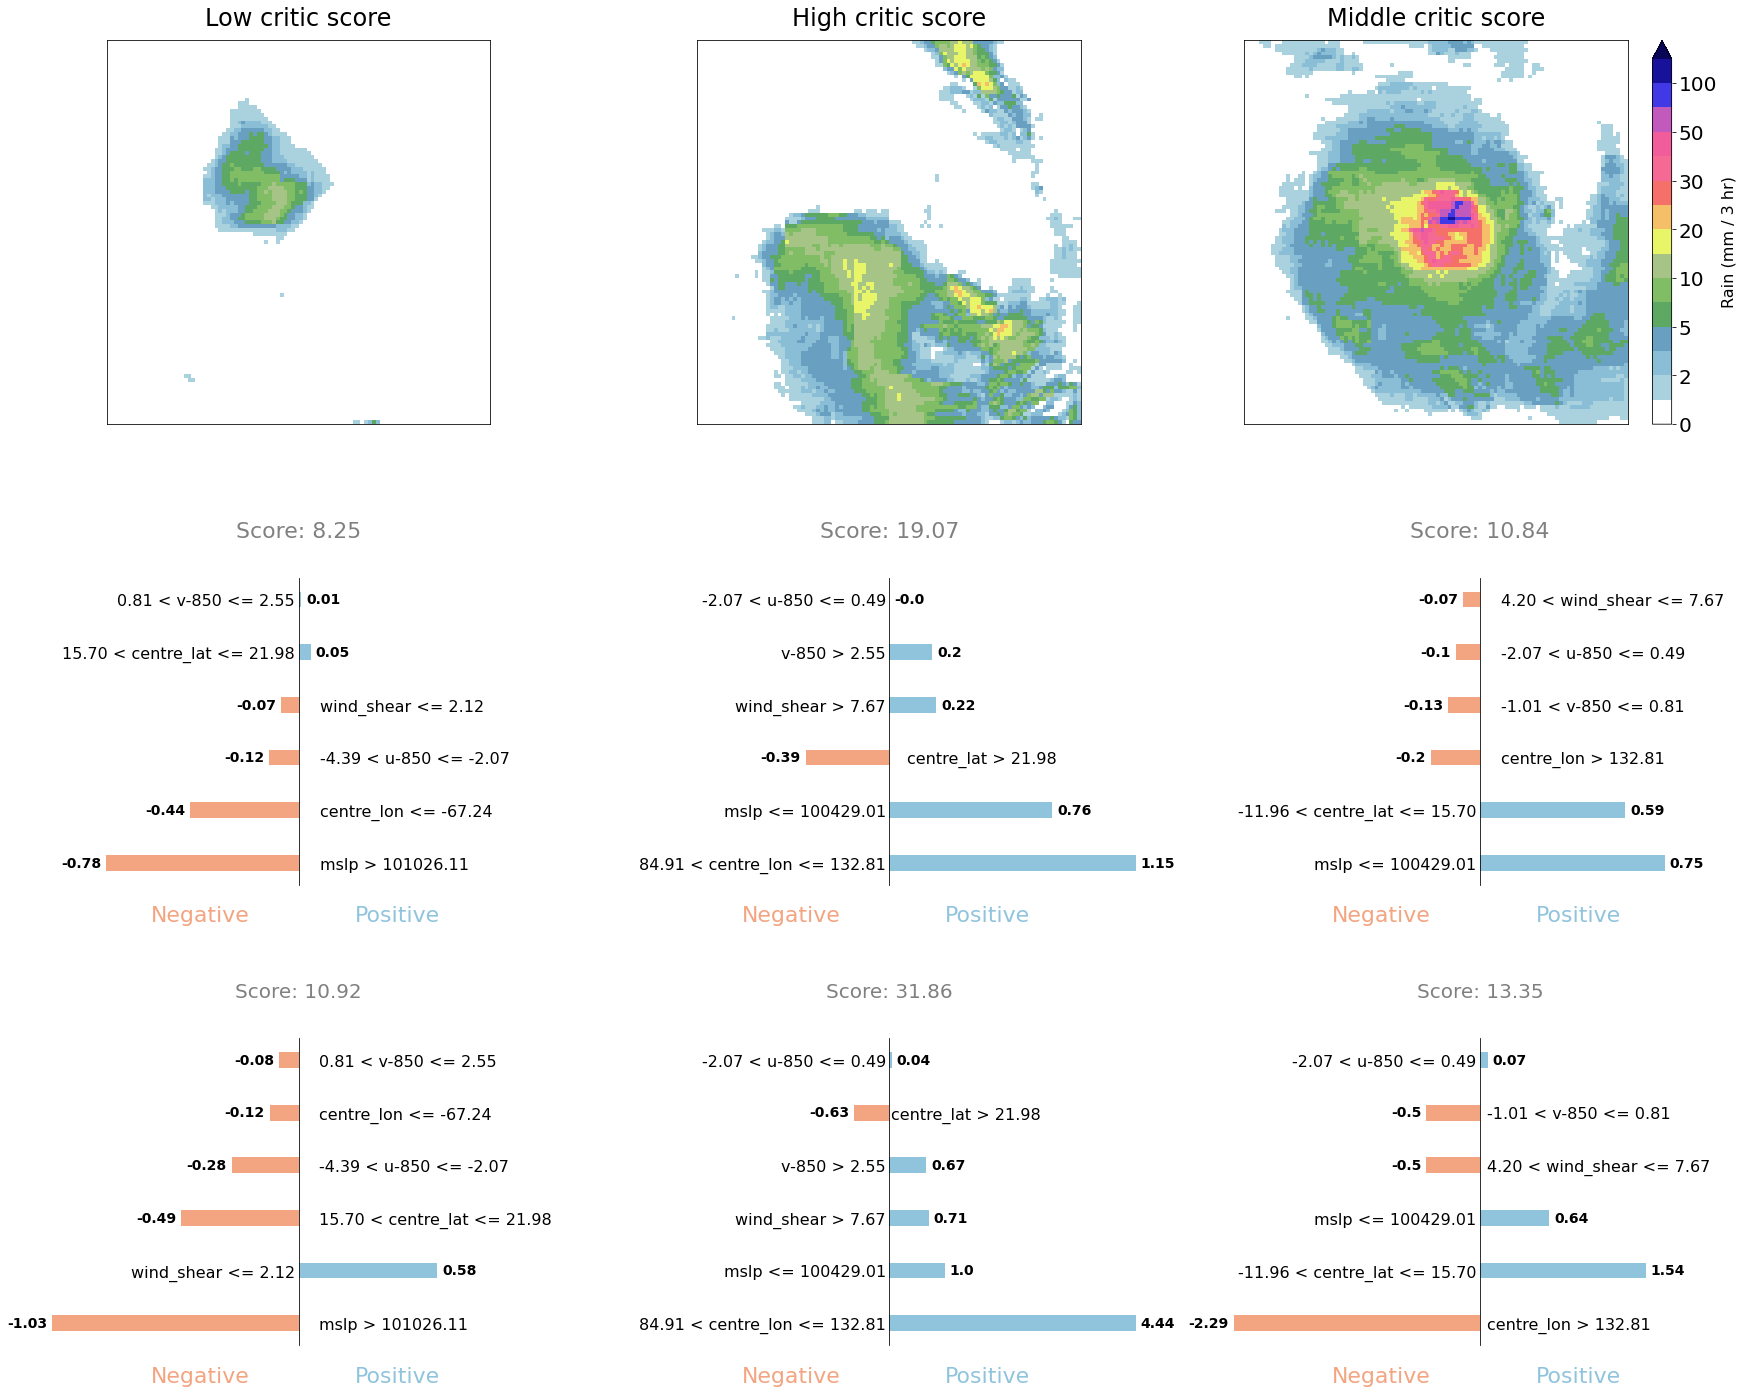

In [214]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(30, 24))

precip_cmap,precip_norm = make_cmap()
precip_clevs = [0, 1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 70, 100, 150]
precip_norm = matplotlib.colors.BoundaryNorm(precip_clevs, precip_cmap.N,extend='max')

# first panel - bad score
rain_i1 = gen_pred1[i1,:,:,0]
m = axes[0,0].imshow(rain_i1,interpolation='nearest',cmap = precip_cmap,norm=precip_norm)
axes[0,0].set_title("Low critic score",size=24,pad=15)
# cb1 = plt.colorbar(m,ax=axes[0,0],label='Rain')

# second panel - good score
rain_j1 = gen_pred1[j1,:,:,0]
m = axes[0,1].imshow(rain_j1,interpolation='nearest',cmap = precip_cmap,norm=precip_norm)
axes[0,1].set_title("High critic score",size=24,pad=15)
# cb1 = plt.colorbar(m,ax=axes[0,1],label='Rain')

# third panel - medium score
rain_976 = gen_pred1[976,:,:,0]
m = axes[0,2].imshow(rain_976,interpolation='nearest',cmap = precip_cmap,norm=precip_norm)
axes[0,2].set_title("Middle critic score",size=24,pad=15)
cb1 = plt.colorbar(m,ax=axes[0,2],label='Rain (mm / 3 hr)')
cb1.ax.tick_params(labelsize=20) 
cb1.set_label(label='Rain (mm / 3 hr)', size=16)

coolwarm_cmap = plt.cm.get_cmap('RdBu')
start_colour = coolwarm_cmap(0.3)
end_colour = coolwarm_cmap(0.7)

# fourth panel - critic 1 explaination
titles = np.array([str(explanation_i1[i][0]) for i in range(6)])
values = np.array([np.round(explanation_i1[i][1],2) for i in range(6)])
colours = color=[start_colour if value < 0 else end_colour for value in values]
bars = axes[1,0].barh(titles,values,color=colours,height=0.3)
axes[1,0].bar_label(bars, values,padding=5, color='black', fontweight='bold',fontsize=14)
axes[1,0].annotate(f'Score: {score_i1[0]:.2f}', xy=(0.5,1.15), xycoords='axes fraction',
            fontsize=22, color='gray', ha='center', va='center')
axes[1,0].set_xlim(-np.max(np.abs(values)),np.max(np.abs(values)))
axes[1,0].spines['left'].set_position(('data', 0))
for i,tick_label in enumerate(axes[1,0].get_yticklabels()):
    if float(values[i]) < 0:
        tick_label.set_horizontalalignment('left')
        x, y = tick_label.get_position()
        tick_label.set_position((x + 0.1, y))


# fifth panel
titles = np.array([str(explanation_j1[i][0]) for i in range(6)])
values = np.array([np.round(explanation_j1[i][1],2) for i in range(6)])
colours = color=[start_colour if value < 0 else end_colour for value in values]
bars = axes[1,1].barh(titles,values,color=colours,height=0.3)
axes[1,1].bar_label(bars, values,padding=5, color='black', fontweight='bold',fontsize=14)
axes[1,1].annotate(f'Score: {score_j1[0]:.2f}', xy=(0.5,1.15), xycoords='axes fraction',
            fontsize=22, color='gray', ha='center', va='center')
axes[1,1].set_xlim(-np.max(np.abs(values)),np.max(np.abs(values)))
axes[1,1].spines['left'].set_position(('data', 0))
for i,tick_label in enumerate(axes[1,1].get_yticklabels()):
    if float(values[i]) < 0:
        tick_label.set_horizontalalignment('left')
        x, y = tick_label.get_position()
        tick_label.set_position((x + 0.1, y))


# sixth panel
titles = np.array([str(explanation_976_1[i][0]) for i in range(6)])
values = np.array([np.round(explanation_976_1[i][1],2) for i in range(6)])
colours = color=[start_colour if value < 0 else end_colour for value in values]
bars = axes[1,2].barh(titles,values,color=colours,height=0.3)
axes[1,2].bar_label(bars, values,padding=5, color='black', fontweight='bold',fontsize=14)
axes[1,2].annotate(f'Score: {score_976_1[0]:.2f}', xy=(0.5,1.15), xycoords='axes fraction',
            fontsize=22, color='gray', ha='center', va='center')
axes[1,2].set_xlim(-np.max(np.abs(values)),np.max(np.abs(values)))
axes[1,2].spines['left'].set_position(('data', 0))
for i,tick_label in enumerate(axes[1,2].get_yticklabels()):
    if float(values[i]) < 0:
        tick_label.set_horizontalalignment('left')
        x, y = tick_label.get_position()
        tick_label.set_position((x + 0.1, y))


# seventh panel
titles = np.array([str(explanation_i2[i][0]) for i in range(6)])
values = np.array([np.round(explanation_i2[i][1],2) for i in range(6)])
colours = color=[start_colour if value < 0 else end_colour for value in values]
bars = axes[2,0].barh(titles,values,color=colours,height=0.3)
axes[2,0].bar_label(bars, values,padding=5, color='black', fontweight='bold',fontsize=14)
axes[2,0].annotate(f'Score: {score_i2[0]:.2f}', xy=(0.5,1.15), xycoords='axes fraction',
            fontsize=20, color='gray', ha='center', va='center')
axes[2,0].set_xlim(-np.max(np.abs(values)),np.max(np.abs(values)))
axes[2,0].spines['left'].set_position(('data', 0))
for i,tick_label in enumerate(axes[2,0].get_yticklabels()):
    if float(values[i]) < 0:
        tick_label.set_horizontalalignment('left')
        x, y = tick_label.get_position()
        tick_label.set_position((x + 0.1, y))


# eigth panel
titles = np.array([str(explanation_j2[i][0]) for i in range(6)])
values = np.array([np.round(explanation_j2[i][1],2) for i in range(6)])
colours = color=[start_colour if value < 0 else end_colour for value in values]
bars = axes[2,1].barh(titles,values,color=colours,height=0.3)
axes[2,1].bar_label(bars, values,padding=5, color='black', fontweight='bold',fontsize=14)
axes[2,1].annotate(f'Score: {score_j2[0]:.2f}', xy=(0.5,1.15), xycoords='axes fraction',
            fontsize=20, color='gray', ha='center', va='center')
axes[2,1].set_xlim(-np.max(np.abs(values)),np.max(np.abs(values)))
axes[2,1].spines['left'].set_position(('data', 0))
for i,tick_label in enumerate(axes[2,1].get_yticklabels()):
    if float(values[i]) < 0:
        tick_label.set_horizontalalignment('left')
        x, y = tick_label.get_position()
        tick_label.set_position((x + 0.1, y))


# ninth panel
titles = np.array([str(explanation_976_2[i][0]) for i in range(6)])
values = np.array([np.round(explanation_976_2[i][1],2) for i in range(6)])
colours = color=[start_colour if value < 0 else end_colour for value in values]
bars = axes[2,2].barh(titles,values,color=colours,height=0.3)
axes[2,2].bar_label(bars, values,padding=5, color='black', fontweight='bold',fontsize=14)
axes[2,2].annotate(f'Score: {score_976_2[0]:.2f}', xy=(0.5,1.15), xycoords='axes fraction',
            fontsize=20, color='gray', ha='center', va='center')
axes[2,2].set_xlim(-np.max(np.abs(values)),np.max(np.abs(values)))
axes[2,2].spines['left'].set_position(('data', 0))
for i,tick_label in enumerate(axes[2,2].get_yticklabels()):
    if float(values[i]) < 0:
        print(tick_label)
        tick_label.set_horizontalalignment('left')
        x, y = tick_label.get_position()
        tick_label.set_position((x + 0.1, y))


for ax in [axes[1,0],axes[1,1],axes[1,2],axes[2,0],axes[2,1],axes[2,2]]:
    
        ax.annotate('Negative', xy=(0.3,-0.1), xycoords='axes fraction',
                fontsize=22, color=start_colour, ha='center', va='center')
        ax.annotate('Positive', xy=(0.7,-0.1), xycoords='axes fraction',
                fontsize=22, color=end_colour, ha='center', va='center')
        # ax.spines['left'].set_position(('data', 0))
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_xticks([-1,1])
        ax.set_xticks([])
        position = ax.get_position()
        new_height = 0.8 * position.height  # Adjust height to 80% of its original value
        new_width = 1 * position.width
        ax.set_position([position.x0, position.y0, new_width, new_height])
        ax.tick_params(axis='y', which='both', length=0)
        ax.yaxis.set_tick_params(labelsize=16)


for ax in [axes[0,0],axes[0,1],axes[0,2]]:
    ax.set_xticks([])
    ax.set_yticks([])




--------------
### Part 2 ###

In [215]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray # since the code wants color images
# from skimage.util.montage import montage2d 

In [237]:
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces()
# make each image color so lime_image works correctly
# define tcs
tcs = gen_pred2[:10000,:,:,0]
# normalise to pretend it's grayscale?
tcs = tcs / tcs.max()
score_mean = critic_pred1.mean()
good_score = critic_pred1 >= score_mean

good_score = good_score[:10000]
# X_vec_face = np.stack([gray2rgb(iimg) for iimg in faces.data.reshape((-1, 64, 64))],0)

y_vec_face = faces.target.astype(np.uint8)
X_vec = np.stack([gray2rgb(iimg) for iimg in tcs.reshape((-1, 100, 100))],0)
y_vec1 = good_score.astype(np.uint8)


tcs = gen_pred2[:10000,:,:,0]
tcs = tcs / tcs.max()
score_mean = critic_pred2.mean()
good_score = critic_pred2 >= score_mean

good_score = good_score[:10000]
# X_vec_face = np.stack([gray2rgb(iimg) for iimg in faces.data.reshape((-1, 64, 64))],0)

y_vec_face = faces.target.astype(np.uint8)
X_vec = np.stack([gray2rgb(iimg) for iimg in tcs.reshape((-1, 100, 100))],0)
y_vec2 = good_score.astype(np.uint8)

In [238]:


class PipeStep(object):
    """
    Wrapper for turning functions into pipeline transforms (no-fitting)
    """
    def __init__(self, step_func):
        self._step_func=step_func
    def fit(self,*args):
        return self
    def transform(self,X):
        return self._step_func(X)

makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list])

simple_rf_pipeline1 = Pipeline([
    ('Make Gray', makegray_step),
    ('Flatten Image', flatten_step),
    ('Normalize', Normalizer()),
    ('PCA', PCA(25)),
    ('XGBoost', GradientBoostingClassifier())
                              ])

simple_rf_pipeline2 = Pipeline([
    ('Make Gray', makegray_step),
    ('Flatten Image', flatten_step),
    ('Normalize', Normalizer()),
    ('PCA', PCA(25)),
    ('XGBoost', GradientBoostingClassifier())
                              ])

In [239]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_vec, y_vec1,
                                                    train_size=0.70)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_vec, y_vec2,
                                                    train_size=0.70)

In [240]:
simple_rf_pipeline1.fit(X_train1, y_train1)

Pipeline(steps=[('Make Gray', <__main__.PipeStep object at 0x7fdc564a5750>),
                ('Flatten Image', <__main__.PipeStep object at 0x7fdc564a5650>),
                ('Normalize', Normalizer()), ('PCA', PCA(n_components=25)),
                ('XGBoost', GradientBoostingClassifier())])

In [241]:
simple_rf_pipeline2.fit(X_train2, y_train2)

In [ ]:
# compute on remaining test data
pipe_pred_test1 = simple_rf_pipeline1.predict(X_test1)
pipe_pred_prop1 = simple_rf_pipeline1.predict_proba(X_test1)

print(classification_report(y_true=y_test1, y_pred = pipe_pred_test1))

# compute on remaining test data
pipe_pred_test2 = simple_rf_pipeline2.predict(X_test2)
pipe_pred_prop2 = simple_rf_pipeline2.predict_proba(X_test2)

print(classification_report(y_true=y_test2, y_pred = pipe_pred_test2))

              precision    recall  f1-score   support

           0       0.64      0.61      0.62       170
           1       0.52      0.55      0.54       130

    accuracy                           0.58       300
   macro avg       0.58      0.58      0.58       300
weighted avg       0.59      0.58      0.58       300

              precision    recall  f1-score   support

           0       0.62      0.75      0.68       173
           1       0.52      0.37      0.43       127

    accuracy                           0.59       300
   macro avg       0.57      0.56      0.56       300
weighted avg       0.58      0.59      0.57       300



In [ ]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime

In [ ]:
from lime.wrappers.scikit_image import SegmentationAlgorithm
explainer = lime_image.LimeImageExplainer(verbose = False)
# segmenter = SegmentationAlgorithm('slic', n_segments=200, compactness=1, sigma=1) # TODO: can change image segmentation algorithm and se what happens, to see contrast in quick changing values
# segmenter = SegmentationAlgorithm('watershed', n_segments=200, compactness=1, sigma=1) #Watersheds are transformations in a grayscale image. Watershed segmentation algorithms treat images like topographic maps, with pixel brightness determining elevation (height). This technique detects lines forming ridges and basins, marking the areas between the watershed lines. It divides images into multiple regions based on pixel height, grouping pixels with the same gray value.
segmenter = SegmentationAlgorithm('felzenszwalb', n_segments=400, compactness=1, sigma=1) # quickshift

In [ ]:
heatmap_976_1 = explain(explainer,976,X_vec,simple_rf_pipeline1,segmenter,data=True)
heatmap_976_2 = explain(explainer,976,X_vec,simple_rf_pipeline2,segmenter,data=True)
# 280 is a good shape

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
heatmap_976_1_block = explain(explainer,976,X_vec,simple_rf_pipeline1,segmenter,block=True,data=True)
heatmap_976_2_block = explain(explainer,976,X_vec,simple_rf_pipeline2,segmenter,block=True,data=True)

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
heatmap_i1_1 = explain(explainer,i1,X_vec,simple_rf_pipeline1,segmenter,data=True)
heatmap_i1_2 = explain(explainer,i1,X_vec,simple_rf_pipeline2,segmenter,data=True)

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
heatmap_i1_1_block = explain(explainer,i1,X_vec,simple_rf_pipeline1,segmenter,block=True,data=True)
heatmap_i1_2_block = explain(explainer,i1,X_vec,simple_rf_pipeline2,segmenter,block=True,data=True)

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
heatmap_j1_1 = explain(explainer,j1,X_vec,simple_rf_pipeline1,segmenter,data=True)
heatmap_j1_2 = explain(explainer,j1,X_vec,simple_rf_pipeline2,segmenter,data=True)

IndexError: index 8522 is out of bounds for axis 0 with size 1000

In [ ]:
heatmap_j1_1_block = explain(explainer,j1,X_vec,simple_rf_pipeline1,segmenter,data=True,block=True)
heatmap_j1_2_block = explain(explainer,j1,X_vec,simple_rf_pipeline2,segmenter,data=True,block=True)

IndexError: index 8522 is out of bounds for axis 0 with size 1000